Perturbation data shape is (11079, 30)


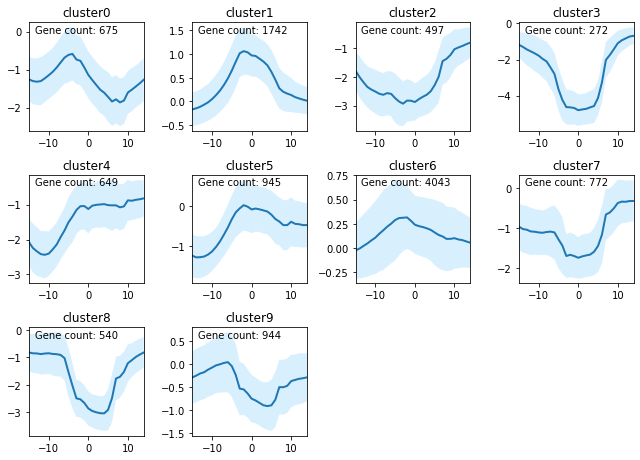

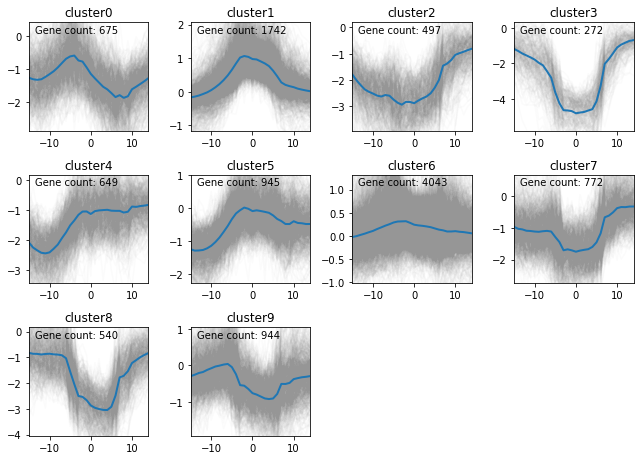

In [5]:
#### dataset to reproduce these results can be found here:
#### https://drive.google.com/file/d/1F8mwXFDC9ufXTsuWQEP6g_PGHD23cGjV/view?usp=sharing

import numpy as np
from scipy import stats
import pickle
import scipy
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.stats import fisher_exact

from riboformer_utils import *
from mpl_toolkits.axes_grid1 import make_axes_locatable

# plot the SIS profiles
def plot_clusters(data, labels, n_clusters, plot_individual_lines=False):
    fig = plt.figure(figsize=(9, 6.5))
    fig.subplots_adjust(hspace=0.0, wspace=0.0)
    
    for i in range(n_clusters):
        ax = fig.add_subplot(3, 4, i + 1)
        cluster_data = data[np.where(labels == i)[0], :].transpose()
        cluster_mean = np.mean(cluster_data, axis=1)
        cluster_std = np.std(cluster_data, axis=1)
        
        if plot_individual_lines:
            ax.plot(np.arange(-15, 15), cluster_data, color='#969696', alpha=0.03)
            ax.set_ylim([min(cluster_mean) - 1, max(cluster_mean) + 1])
        else:
            ax.fill_between(np.arange(-15, 15), cluster_mean - cluster_std,
                        cluster_mean + cluster_std, facecolor='#d8f0fe', alpha=1.0, edgecolor='none')
        
        ax.plot(np.arange(-15, 15), cluster_mean, linewidth=2)
        ax.set_title(f'cluster{i}')
        ax.set_xlim([-15, 14])
        
        # Insert gene number text
        gene_number = len(np.where(labels == i)[0])
        ax.text(0.05, 0.9, f'Gene count: {gene_number}', transform=ax.transAxes)
    
    fig.tight_layout()
    plt.show()

# change this to the new data path
outpath = "../Datasets/"
input_folder = 'GSE139036 disome/'
filepath = outpath + input_folder

DNA_relevance = np.loadtxt(filepath + 'Disome_SIS.txt', delimiter="\t")
pause_indices = np.loadtxt(filepath + 'Disome_pause_indices.txt', delimiter="\t").astype(int)[:, 0]

print(f"Perturbation data shape is {DNA_relevance.shape}")

n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(DNA_relevance)
labels = kmeans.labels_

# Plot mean and standard deviations
plot_clusters(DNA_relevance, labels, n_clusters)

# Plot individual lines
plot_clusters(DNA_relevance, labels, n_clusters, plot_individual_lines=True)


#### reproduce figure 2b

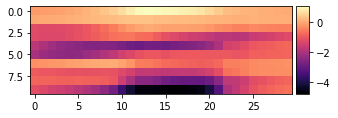

In [6]:
def plot_heatmap(data, labels, n_clusters, node_order, cmap='magma'):
    cluster_means = np.array([np.mean(data[np.where(labels == i)[0], :].transpose(), axis=1) for i in range(n_clusters)])

    fig, ax = plt.subplots(figsize=(5, 5))
    im = ax.imshow(cluster_means[node_order, :], cmap=cmap)

    # create an axes on the right side of ax. The width of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.05 inch.
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    plt.colorbar(im, cax=cax)
    plt.show()

# Usage example
node_list = [1, 6, 5, 0, 2, 4, 9, 7, 8, 3]
plot_heatmap(DNA_relevance, labels, n_clusters, node_order=node_list)

In [7]:
# load processed data file
x_c_total = np.loadtxt(filepath + 'Disome_xc.txt',  delimiter="\t")  

#### reproduce figure 2e

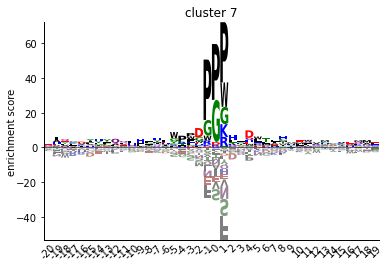

In [9]:
import logomaker

def get_key(val, my_dict):
    for key, value in my_dict.items():
        if val in value:
            return key
    return "key doesn't exist " + val

def calculate_enrichment_score(AA_list, Pause_score_AA, labels, cluster, codon_table, x_c, idx_pause):
    # Calculate enrichment scores for each AA position
    AA_enrich = np.zeros([len(AA_list), 40])
    AA_random = np.zeros([len(AA_list), 40])

    for i, label in enumerate(labels):
        if label == cluster:
            temp = idx_pause[i]
            AA_seq = [get_key(codon_table[int(x)], Pause_score_AA) for x in x_c[temp][-40:]]
            if len(''.join(AA_seq)) == 40:
                for j, aa in enumerate(AA_seq):
                    AA_enrich[AA_list.index(aa), j] += 1

        idx_r = np.random.randint(0, len(x_c))
        AA_seq = [get_key(codon_table[int(x)], Pause_score_AA) for x in x_c[idx_r][-40:]]
        if len(''.join(AA_seq)) == 40:
            for j, aa in enumerate(AA_seq):
                AA_random[AA_list.index(aa), j] += 1

    enrichment_score = np.zeros([len(AA_list), 40])
    for i in range(len(AA_list)):
        for j in range(40):
            oddsratio, pvalue = fisher_exact([[AA_random[i, j], AA_enrich[i, j]],
                                              [sum(AA_random[:, j]), sum(AA_enrich[:, j])]])
            enrichment_score[i, j] = np.log10(pvalue)
            if AA_enrich[i, j]/sum(AA_enrich[:, j]) > AA_random[i, j]/sum(AA_random[:, j]):
                enrichment_score[i, j] = enrichment_score[i, j]*-1

    return enrichment_score.transpose()

def plot_enrichment_score(AA_list, enrichment_score, cluster):
    df = pd.DataFrame(enrichment_score,
                      index=pd.Index(np.arange(-20, 20), name='pos'),
                      columns=pd.Index(AA_list))

    crp_logo = logomaker.Logo(df,
                              shade_below=.5,
                              fade_below=.5,
                              figsize=[6, 4],
                              color_scheme='chemistry')

    crp_logo.style_spines(visible=False)
    crp_logo.style_spines(spines=['left', 'bottom'], visible=True)
    crp_logo.style_xticks(rotation=45, fmt='%d', anchor=0)

    crp_logo.ax.set_ylabel("enrichment score", labelpad=-1)
    crp_logo.ax.xaxis.set_ticks_position('none')
    crp_logo.ax.xaxis.set_tick_params(pad=-1)
    crp_logo.ax.set_title(f"cluster {cluster}")

    fig = crp_logo.fig.get_figure()
    plt.show()

# Usage example
cluster = 7
pause_scores_aa = {k: pause_scores_aa[k] for k in sorted(pause_scores_aa)}
pause_score_keys = list(pause_scores_aa.keys())
enrichment_score = calculate_enrichment_score(pause_score_keys, pause_scores_aa, labels, cluster, codon_table, x_c_total, pause_indices)
plot_enrichment_score(pause_score_keys, enrichment_score, cluster)


#### reproduce figure 2c

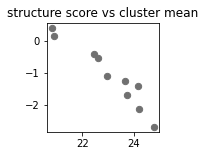

In [11]:

def load_structure_scores(file_path):
    with open(file_path + 'structure_scores.pkl', 'rb') as f:
        [Structure_enrich_dict, Structure_enrich_dict2] = pickle.load(f)
    return Structure_enrich_dict, Structure_enrich_dict2

def calculate_cluster_structure(n_clusters, Structure_enrich_dict, Structure_enrich_dict2):
    clus_structure = np.zeros([n_clusters, 2])
    for p in range(n_clusters):
        clus_structure[p, 0] = np.mean(Structure_enrich_dict[str(p)])
        clus_structure[p, 1] = np.mean(Structure_enrich_dict2[str(p)])
    return clus_structure

def get_cluster_stats(n_clusters, labels, DNA_relevance):
    clus_stats = {}
    clus_stats['mean'] = [np.average(DNA_relevance[np.where(labels == p)[0], :]) for p in range(n_clusters)]
    return clus_stats

def plot_structure_score_vs_cluster_mean(clus_structure, clus_stats):
    fig, ax = plt.subplots(figsize=(2, 2))
    plt.scatter(clus_structure[:, 0], clus_stats['mean'], s=40, color='#707070')
    plt.title('structure score vs cluster mean')
    plt.show()

Structure_enrich_dict, Structure_enrich_dict2 = load_structure_scores(filepath)
clus_structure = calculate_cluster_structure(n_clusters, Structure_enrich_dict, Structure_enrich_dict2)
clus_stats = get_cluster_stats(n_clusters, labels, DNA_relevance)
plot_structure_score_vs_cluster_mean(clus_structure, clus_stats)
